In [1]:
import os,random,itertools,matplotlib
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
# Umitools
from umi_tools._dedup_umi import edit_distance
matplotlib.rcParams['font.family'] = 'Helvetica'

def str2array(s):
    a,b= s.split('\t')[:2]
    return (a,int(b))

def merge_edit_1(counts):
    keep,collapse = [],counts[0:]
    while len(collapse)>0:
        ref = list(collapse[0]) # need to convert to list here otherwise will keep updating the value to new_cluster
        temp = []
        for s in collapse[1:]:
            s1 = ref[0]
            s2 = s[0]
            if abs(len(s1)-len(s2))<=1 and edit_distance(s1.encode('utf-8'),s2.encode('utf-8'))<2:
                ref[-1] += s[-1]
            else:
                temp.append(s)
        keep.append(ref)
        collapse = temp[0:]
    return np.array(keep,dtype=object)

def reverse_complement(seq):
    """This function returns the reverse_complement sequence of the input sequence
    from 3' to 5' """
    complement = {'A':'T', 'C':'G','G':'C', 'T':'A', 'N':'N'}
    rcomp_seq = ''
    for base in seq:
        rcomp_seq = complement[base] + rcomp_seq
    return rcomp_seq
%matplotlib inline


# Overall recording efficiency
Supp Figure 8c 

In [4]:
## Dox mesc
path = '../Figure5/' ## change
edit = []
times = ['mESC-dox']
for time in times:
    ed = [time]
    df_hek = pd.read_table('../Figure5/synEn_designs.txt')
    samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
    for i in range(0,3):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==0 or  len(a[0])==5]) if s[1]>10],columns=['barcode','count'])
            test['barcode']=test['barcode'].apply(reverse_complement)
        ed.append(list(1-test[test['barcode']=='']['count']/test['count'].sum())[0]*100)
    edit.append(ed)

times = ['0-24','24-48','48-72','72-96','96-120']

for time in times:
    samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
    df_hek = pd.read_table('../Figure5/synEn_designs.txt')
    ed = [time]
    for i in range(0,2):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==0 or  len(a[0])==5]) if s[1]>10],columns=['barcode','count'])
            test['barcode']=test['barcode'].apply(reverse_complement)
        ed.append(list(1-test[test['barcode']=='']['count']/test['count'].sum())[0]*100)
    edit.append(ed)
df = pd.DataFrame(edit,columns=['time','rep1','rep2','rep3'])
df_melt = df.melt(id_vars='time')

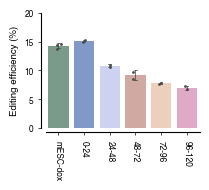

In [7]:
fig, axs = plt.subplots(figsize=(2,1.5),sharey=False,sharex=False)
g=sns.barplot(data=df_melt, x="time", y='value', errwidth=0.5, errorbar='sd', palette=['#76A08A','#7496D2','#C7CEF6','#D8A49B','#F5CDB6','#E6A2C5','#FDDDA4','#F7B0AA'], capsize=.1, ax=axs) 
sns.stripplot(data=df_melt, x="time", y='value',dodge=True,color="#4A4A4A",marker='.',size=4,ax=axs)
sns.despine(offset=3)
axs.set_ylim(0,20)
start, end = axs.get_ylim()
axs.set_xlabel('');
g.set_box_aspect(4.5/len(g.patches))
start, end = axs.get_ylim()
axs.set_ylabel('Editing efficiency (%)',fontsize=7)
axs.xaxis.set_tick_params(width=0.5, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.5, length=2,labelsize=6)
axs.set_xticklabels(axs.get_xticklabels(),rotation=-90);

#plt.savefig('../Figure5/figs/Supp9a.pdf')

# Check if sample are correlated
Supp Figure a,d 

In [8]:
design_table = pd.read_table( '../Figure5/98_TF_motif_designs.csv',header=None,sep=',')

## dox mesc

mESC-dox_rep1
mESC-dox_rep2
mESC-dox_rep3


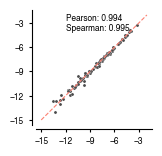

In [9]:
## Dox mesc
path = '../Figure5/'
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and 'mESC-dox' in s])
df_ctrl = pd.read_table('../Figure5/synEn_designs.txt')
for i in range(0,3):
    print (samples[i])
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]) if s[1]>5],columns=['barcode','count'])
        test['barcode']=test['barcode'].apply(reverse_complement)
        test['count'] = test['count']
        df_ctrl=df_ctrl.merge(test,on='barcode',how='inner').fillna(0)
df_ctrl.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2','Hek293_rep3']
df_ctrl['Hek_ratio_rep1'] =  np.log2((df_ctrl['Hek293_rep1'])/(df_ctrl['Hek293_rep1'].sum()))#*10**6
df_ctrl['Hek_ratio_rep2'] =  np.log2((df_ctrl['Hek293_rep2'])/(df_ctrl['Hek293_rep2'].sum()))#*10**6
df_ctrl['Hek_ratio_rep3'] =  np.log2((df_ctrl['Hek293_rep3'])/(df_ctrl['Hek293_rep3'].sum()))#*10**6

df_ctrl['ratio'] =  (df_ctrl['Hek_ratio_rep1']+df_ctrl['Hek_ratio_rep2']++df_ctrl['Hek_ratio_rep3'])/3#*10**6

fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
sample = [('Hek_ratio_rep1','Hek_ratio_rep2')]
for i in range(1):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_ctrl, color=['#4A4A4A'],s=5,ax=axs,marker='o')
    pr = sp.stats.pearsonr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sr = sp.stats.spearmanr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sns.despine(offset=3)
    start, end = -15,0
    axs.yaxis.set_ticks(np.arange(start, end, 3))
    axs.xaxis.set_ticks(np.arange(start, end, 3))
    axs.text(-12,-4,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs.set_xlabel('')
    axs.set_ylabel('')#s[1])
    axs.plot([start, -2],[start, -2],'--',color='#FB8072',linewidth=0.8)
    axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig('../Figure5/figs/mesc_dox.pdf')

## gas 0-24

mESC-gas-0-24-dox_rep1
mESC-gas-0-24-dox_rep2


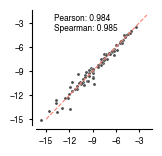

In [10]:
## Dox mesc
path = '../Figure5/'
time = '0-24'
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
df_ctrl = pd.read_table('../Figure5/synEn_designs.txt')
for i in range(0,2):
    print (samples[i])
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]) if s[1]>5],columns=['barcode','count'])
        test['barcode']=test['barcode'].apply(reverse_complement)
        test['count'] = test['count']
        df_ctrl=df_ctrl.merge(test,on='barcode',how='inner').fillna(0)
df_ctrl.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2']
df_ctrl['Hek_ratio_rep1'] =  np.log2((df_ctrl['Hek293_rep1'])/(df_ctrl['Hek293_rep1'].sum()))#*10**6
df_ctrl['Hek_ratio_rep2'] =  np.log2((df_ctrl['Hek293_rep2'])/(df_ctrl['Hek293_rep2'].sum()))#*10**6

df_ctrl['ratio'] =  (df_ctrl['Hek_ratio_rep1']+df_ctrl['Hek_ratio_rep2'])/2#*10**6

fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
sample = [('Hek_ratio_rep1','Hek_ratio_rep2')]
for i in range(1):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_ctrl, color=['#4A4A4A'],s=5,ax=axs,marker='o')
    pr = sp.stats.pearsonr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sr = sp.stats.spearmanr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sns.despine(offset=3)
    start, end = -15,0
    axs.yaxis.set_ticks(np.arange(start, end, 3))
    axs.xaxis.set_ticks(np.arange(start, end, 3))
    axs.text(-14,-4,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs.set_xlabel('')
    axs.set_ylabel('')#s[1])
    axs.plot([start, -2],[start, -2],'--',color='#FB8072',linewidth=0.8)
    axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig(f'../Figure5/figs/mesc_{time}.pdf')

## gas 24-28

mESC-gas-24-48-dox_rep1
mESC-gas-24-48-dox_rep2


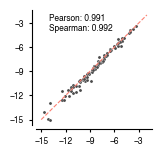

In [11]:
## Dox mesc
path = '../Figure5/'
time = '24-48'
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
df_ctrl = pd.read_table('../Figure5/synEn_designs.txt')
for i in range(0,2):
    print (samples[i])
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]) if s[1]>5],columns=['barcode','count'])
        test['barcode']=test['barcode'].apply(reverse_complement)
        test['count'] = test['count']
        df_ctrl=df_ctrl.merge(test,on='barcode',how='inner').fillna(0)
df_ctrl.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2']
df_ctrl['Hek_ratio_rep1'] =  np.log2((df_ctrl['Hek293_rep1'])/(df_ctrl['Hek293_rep1'].sum()))#*10**6
df_ctrl['Hek_ratio_rep2'] =  np.log2((df_ctrl['Hek293_rep2'])/(df_ctrl['Hek293_rep2'].sum()))#*10**6

df_ctrl['ratio'] =  (df_ctrl['Hek_ratio_rep1']+df_ctrl['Hek_ratio_rep2'])/2#*10**6

fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
sample = [('Hek_ratio_rep1','Hek_ratio_rep2')]
for i in range(1):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_ctrl, color=['#4A4A4A'],s=5,ax=axs,marker='o')
    pr = sp.stats.pearsonr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sr = sp.stats.spearmanr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sns.despine(offset=3)
    start, end = -15,0
    axs.yaxis.set_ticks(np.arange(start, end, 3))
    axs.xaxis.set_ticks(np.arange(start, end, 3))
    axs.text(-14,-4,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs.set_xlabel('')
    axs.set_ylabel('')#s[1])
    axs.plot([start, -2],[start, -2],'--',color='#FB8072',linewidth=0.8)
    axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig(f'../Figure5/figs/mesc_{time}.pdf')

## gas 48-72

mESC-gas-48-72-dox_rep1
mESC-gas-48-72-dox_rep2


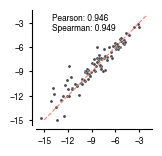

In [12]:
## Dox mesc
path = '../Figure5/'
time = '48-72'
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
df_ctrl = pd.read_table('../Figure5/synEn_designs.txt')
for i in range(0,2):
    print (samples[i])
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]) if s[1]>5],columns=['barcode','count'])
        test['barcode']=test['barcode'].apply(reverse_complement)
        test['count'] = test['count']
        df_ctrl=df_ctrl.merge(test,on='barcode',how='inner').fillna(0)
df_ctrl.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2']
df_ctrl['Hek_ratio_rep1'] =  np.log2((df_ctrl['Hek293_rep1'])/(df_ctrl['Hek293_rep1'].sum()))#*10**6
df_ctrl['Hek_ratio_rep2'] =  np.log2((df_ctrl['Hek293_rep2'])/(df_ctrl['Hek293_rep2'].sum()))#*10**6

df_ctrl['ratio'] =  (df_ctrl['Hek_ratio_rep1']+df_ctrl['Hek_ratio_rep2'])/2#*10**6

fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
sample = [('Hek_ratio_rep1','Hek_ratio_rep2')]
for i in range(1):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_ctrl, color=['#4A4A4A'],s=5,ax=axs,marker='o')
    pr = sp.stats.pearsonr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sr = sp.stats.spearmanr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sns.despine(offset=3)
    start, end = -15,0
    axs.yaxis.set_ticks(np.arange(start, end, 3))
    axs.xaxis.set_ticks(np.arange(start, end, 3))
    axs.text(-14,-4,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs.set_xlabel('')
    axs.set_ylabel('')#s[1])
    axs.plot([start, -2],[start, -2],'--',color='#FB8072',linewidth=0.8)
    axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig(f'../Figure5/figs/mesc_{time}.pdf')

## gas 72-96

mESC-gas-72-96-dox_rep1
mESC-gas-72-96-dox_rep2


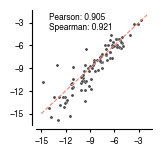

In [13]:
## Dox mesc
path = '../Figure5/'
time = '72-96'
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
df_ctrl = pd.read_table('../Figure5/synEn_designs.txt')
for i in range(0,2):
    print (samples[i])
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]) if s[1]>5],columns=['barcode','count'])
        test['barcode']=test['barcode'].apply(reverse_complement)
        test['count'] = test['count']
        df_ctrl=df_ctrl.merge(test,on='barcode',how='inner').fillna(0)
df_ctrl.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2']
df_ctrl['Hek_ratio_rep1'] =  np.log2((df_ctrl['Hek293_rep1'])/(df_ctrl['Hek293_rep1'].sum()))#*10**6
df_ctrl['Hek_ratio_rep2'] =  np.log2((df_ctrl['Hek293_rep2'])/(df_ctrl['Hek293_rep2'].sum()))#*10**6

df_ctrl['ratio'] =  (df_ctrl['Hek_ratio_rep1']+df_ctrl['Hek_ratio_rep2'])/2#*10**6

fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
sample = [('Hek_ratio_rep1','Hek_ratio_rep2')]
for i in range(1):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_ctrl, color=['#4A4A4A'],s=5,ax=axs,marker='o')
    pr = sp.stats.pearsonr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sr = sp.stats.spearmanr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sns.despine(offset=3)
    start, end = -15,0
    axs.yaxis.set_ticks(np.arange(start, end, 3))
    axs.xaxis.set_ticks(np.arange(start, end, 3))
    axs.text(-14,-4,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs.set_xlabel('')
    axs.set_ylabel('')#s[1])
    axs.plot([start, -2],[start, -2],'--',color='#FB8072',linewidth=0.8)
    axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
##plt.savefig(f'../Figure5/figs/mesc_{time}.pdf')

## gas 96-120

mESC-gas-96-120-dox_rep1
mESC-gas-96-120-dox_rep2


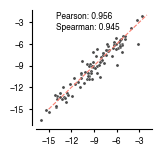

In [14]:
## Dox mesc
path = '../Figure5/'
time = '96-120'
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
df_ctrl = pd.read_table('../Figure5/synEn_designs.txt')
for i in range(0,2):
    print (samples[i])
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]) if s[1]>5],columns=['barcode','count'])
        test['barcode']=test['barcode'].apply(reverse_complement)
        test['count'] = test['count']
        df_ctrl=df_ctrl.merge(test,on='barcode',how='inner').fillna(0)
df_ctrl.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2']
df_ctrl['Hek_ratio_rep1'] =  np.log2((df_ctrl['Hek293_rep1'])/(df_ctrl['Hek293_rep1'].sum()))#*10**6
df_ctrl['Hek_ratio_rep2'] =  np.log2((df_ctrl['Hek293_rep2'])/(df_ctrl['Hek293_rep2'].sum()))#*10**6

df_ctrl['ratio'] =  (df_ctrl['Hek_ratio_rep1']+df_ctrl['Hek_ratio_rep2'])/2#*10**6

fig, axs = plt.subplots(1,figsize=(1.5,1.5),sharey=False,sharex=False)
sample = [('Hek_ratio_rep1','Hek_ratio_rep2')]
for i in range(1):
    s=sample[i]
    sns.scatterplot(x=s[0],y=s[1],data = df_ctrl, color=['#4A4A4A'],s=5,ax=axs,marker='o')
    pr = sp.stats.pearsonr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sr = sp.stats.spearmanr(df_ctrl[s[0]],df_ctrl[s[1]])[0]
    sns.despine(offset=3)
    start, end = -15,0
    axs.yaxis.set_ticks(np.arange(start, end, 3))
    axs.xaxis.set_ticks(np.arange(start, end, 3))
    axs.text(-14,-4,"Pearson: "  + str(round(pr,3))  + "\nSpearman: "+str(round(sr,3)),fontsize=6)
    axs.set_xlabel('')
    axs.set_ylabel('')#s[1])
    axs.plot([start, -2],[start, -2],'--',color='#FB8072',linewidth=0.8)
    axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
    axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig(f'../Figure5/figs/mesc_{time}.pdf')

# mESC vs Gastruloid count table
create table for DEseq

In [15]:
## Dox mesc
path = '../Figure5/'
times = ['0-24','24-48','48-72','72-96','96-120']
df_hek = pd.read_table('../Figure5/synEn_designs.txt')
df_deseq = pd.DataFrame(df_hek['motif']) # pd.DataFrame(df_hek[['motif','barcode']])
for time in times:
    df_hek = pd.read_table('../Figure5/synEn_designs.txt')
    samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
    for i in range(0,2):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5])],columns=['barcode','count'])
            test = test[test['count']>test['count'].sum()/2**14].reset_index(drop=True)
            test['barcode']=test['barcode'].apply(reverse_complement)
            total = test['count'].sum()
            df_hek=df_hek.merge(test,on='barcode',how='left').fillna(round(total/2**14))  
    df_hek.columns =  ['motif','barcode','barcode_rc','Sequence',f'{time}_rep1',f'{time}_rep2']
    df_deseq = df_deseq.merge(df_hek[['motif',f'{time}_rep1',f'{time}_rep2']],on='motif',how='left')


times = ['mESC-dox']
for time in times:
    df_hek = pd.read_table('../Figure5/synEn_designs.txt')
    samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
    for i in range(0,3):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5])],columns=['barcode','count'])
            test = test[test['count']>test['count'].sum()/2**14].reset_index(drop=True)
            test['barcode']=test['barcode'].apply(reverse_complement)
            total = test['count'].sum()
            df_hek=df_hek.merge(test,on='barcode',how='left').fillna(round(total/2**14))
    df_hek.columns =  ['motif','barcode','barcode_rc','Sequence',f'{time}_rep1',f'{time}_rep2',f'{time}_rep3']
    df_deseq = df_deseq.merge(df_hek[['motif',f'{time}_rep1',f'{time}_rep2',f'{time}_rep3']],on='motif',how='left')

In [16]:
df_deseq.columns = df_deseq.columns.str.replace('-','.').str.replace('__','_').str.replace('_','.')
df_deseq.to_csv('../Figure5/mESC_gas_tf_recording.csv', sep=',',index=False)

In [17]:
coldata = pd.DataFrame([df_deseq.columns[1:],df_deseq.columns[1:].str.split('.rep').str[0]]).T
coldata.to_csv('../Figure5/coldata_mESC_gas.csv',sep=',',index=False)

## mESC vs Gastruloid differential active recorders
Supp Figure 8e 

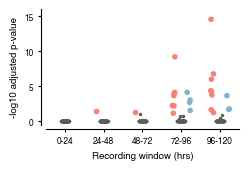

In [18]:
times = ['0.24','24.48','48.72','72.96','96.120']
df = pd.DataFrame(columns=['log2FoldChange','ratio','time','label'])
for time in times:
    f = pd.read_csv(f'../Figure5/{time}_deseq.txt')[['rowname','log2FoldChange','padj']]
    f['ratio'] = 0- f['padj'].apply(float).apply(np.log10)
    f['time'] = time.replace('.','-')
    f['log2FoldChange'] = f['log2FoldChange'].apply(float)
    f['label'] = ''
    f['sig'] = f['ratio']>-np.log10(0.1)
    f.loc[(f['log2FoldChange'] > 0)&(f['ratio']>0),'label'] ='increase'
    f.loc[(f['log2FoldChange'] < 0)&(f['ratio']>0),'label'] ='decrease'
    df = pd.concat([df,f[['log2FoldChange','ratio','time','label']]],axis=0)
df = df.reset_index(drop=True)
df['sig'] = df['ratio']>-np.log10(0.1)
fig, axs = plt.subplots(1,figsize=(2.5,1.5),sharey=False,sharex=False)
sns.stripplot(x='time',y='ratio',dodge=True,data = df[df['sig']],palette=['#FB8072','#80B1D3'],s=4,
              order=['0-24', '24-48', '48-72', '72-96', '96-120'],hue='label',ax=axs,marker='o',legend=False)
sns.stripplot(x='time',y='ratio',dodge=True,data = df[df['sig']==False],color='#5C5C5C',s=2.5, 
              order=['0-24', '24-48', '48-72', '72-96', '96-120'],ax=axs,marker='o',legend=False)
sns.despine(offset=3)
axs.set_xlabel('Recording window (hrs)', fontsize=7)
axs.set_ylabel('-log10 adjusted p-value',fontsize=7)#s[1])
axs.set_ylim(-0.5,16)
#axs.set_xticks([0,1,2,3,4],['24','48','72','96','120'])
axs.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
axs.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig(f'../Figure5/figs/mesc_deseq_significance.pdf')

# mESC vs other cells count table

In [19]:
path = '../Figure2/synEN/'
samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if 'HEK293T' in s and '.tsv' in s])
df_hek = pd.read_table(path+'synEn_designs.txt')
for i in range(3):
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5] ),columns=['barcode','count'])
        test = test[test['count']>test['count'].sum()/2**14].reset_index(drop=True)
        total = test['count'].sum()
        df_hek=df_hek.merge(test,on='barcode',how='left').fillna(round(total/2**14))  
df_hek.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2','Hek293_rep3']

samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if 'K562' in s and '.tsv' in s])
df_k562 = pd.read_table(path+'synEn_designs.txt')
for i in range(3):
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame(merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]),columns=['barcode','count'])
        test = test[test['count']>test['count'].sum()/2**14].reset_index(drop=True)
        total = test['count'].sum()
        df_k562=df_k562.merge(test,on='barcode',how='left').fillna(round(total/2**14))  
df_k562.columns =  ['motif','barcode','barcode_rc','Sequence','K562_rep1','K562_rep2','K562_rep3']


In [20]:
df_esc = pd.read_table('../Figure5/synEn_designs.txt')
path = '../Figure5/'
samples = sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and 'mESC-dox' in s])
for i in range(0,3):
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5])],columns=['barcode','count'])
        test['barcode']=test['barcode'].apply(reverse_complement)
        test = test[test['count']>test['count'].sum()/2**14].reset_index(drop=True)
        total = test['count'].sum()
        df_esc=df_esc.merge(test,on='barcode',how='inner').fillna(round(total/2**14))
df_esc.columns =  ['motif','barcode','barcode_rc','Sequence','mESC_rep1','mESC_rep2','mESC_rep3']

In [21]:
df_esc.merge(df_hek.merge(df_k562,on='barcode',how='outer'),on='barcode',how='outer').fillna(1).loc[:,('barcode','K562_rep1','K562_rep2','K562_rep3','Hek293_rep1','Hek293_rep2','Hek293_rep3','mESC_rep1','mESC_rep2','mESC_rep3')].to_csv( '../Figure5/mESC_hek_k562_comparison_deseq.csv',index=False)

In [22]:
coldata = pd.DataFrame([('K562_rep1','K562_rep2','K562_rep3','Hek293_rep1','Hek293_rep2','Hek293_rep3','mESC_rep1','mESC_rep2','mESC_rep3'),
                        ('K562','K562','K562','Hek293','Hek293','Hek293','mESC','mESC','mESC')]).T
coldata.to_csv('../Figure5/coldata_mESC_Hek293T_K562.csv',index=False)

## Figure 5e

In [23]:
## Dox mesc
path = '../Figure5/'
times = ['0-24','24-48','48-72','72-96','96-120']

ratios = pd.DataFrame(pd.read_table('../Figure5/synEn_designs.txt')['motif'],columns=['motif'])
k = 0
for time in times:
    samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
    df_hek = pd.read_table('../Figure5/synEn_designs.txt')
    for i in range(0,2):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5])],columns=['barcode','count'])
            test = test[test['count']>test['count'].sum()/2**14].reset_index(drop=True)
            test['barcode']=test['barcode'].apply(reverse_complement)
            total = test['count'].sum()
            df_hek=df_hek.merge(test,on='barcode',how='left').fillna(round(total/2**14))  
    df_hek.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2']
    df_hek['Hek293_rep1'] = df_hek['Hek293_rep1'].astype(float, copy=True)
    df_hek['Hek293_rep2'] = df_hek['Hek293_rep2'].astype(float, copy=True)
    df_hek['Hek_ratio_rep1'] =  np.log2((df_hek['Hek293_rep1'])/(df_hek['Hek293_rep1'].sum()))#*10**6
    df_hek['Hek_ratio_rep2'] =  np.log2((df_hek['Hek293_rep2'])/(df_hek['Hek293_rep2'].sum()))#*10**6

    df_hek['ratio_mean'] =  (df_hek['Hek_ratio_rep1']+df_hek['Hek_ratio_rep2'])/2#*10**6
    ratios = ratios.merge(df_hek[['motif','ratio_mean']],on='motif',how='left')
    ratios.columns = ['motif'] + times[0:k+1]
    k+=1

times = ['mESC-dox']
k=0
for time in times:
    df_hek = pd.read_table('../Figure5/synEn_designs.txt')
    samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
    for i in range(0,3):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5])],columns=['barcode','count'])
            test = test[test['count']>test['count'].sum()/2**14].reset_index(drop=True)
            test['barcode']=test['barcode'].apply(reverse_complement)
            total = test['count'].sum()
            df_hek=df_hek.merge(test,on='barcode',how='left').fillna(round(total/2**14))  
    df_hek.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2','Hek293_rep3']
    
    df_hek['Hek293_rep1'] = df_hek['Hek293_rep1'].astype(float, copy=True)
    df_hek['Hek293_rep2'] = df_hek['Hek293_rep2'].astype(float, copy=True)
    df_hek['Hek293_rep3'] = df_hek['Hek293_rep3'].astype(float, copy=True)
    
    df_hek['Hek_ratio_rep1'] =  np.log2((df_hek['Hek293_rep1'])/(df_hek['Hek293_rep1'].sum()))#*10**6
    df_hek['Hek_ratio_rep2'] =  np.log2((df_hek['Hek293_rep2'])/(df_hek['Hek293_rep2'].sum()))#*10**6
    df_hek['Hek_ratio_rep3'] =  np.log2((df_hek['Hek293_rep3'])/(df_hek['Hek293_rep3'].sum()))#*10**6

    df_hek['ratio_mean'] =  (df_hek['Hek_ratio_rep1']+df_hek['Hek_ratio_rep2']+df_hek['Hek_ratio_rep3'])/3#*10**6
    ratios = ratios.merge(df_hek[['motif','ratio_mean']],on='motif',how='left')
    ratios.columns = ['motif','0-24','24-48','48-72','72-96','96-120','background'] 
    k+=1


In [24]:
motifs = ['AAAGATCAAAGGAA',  'AATCCACA','ACTTCCGGT', 'AAGGTCAATGACCTT',  # wnt, nodal, ets, rar_v3
          'TACCCACAATGCATTG','CGAAACCGAAACT',     # ZNF143, IRF1
          'GCAATAAAA', 'TCTTATCT', 'CATAAATCAT',  # CDX1/2, GATA, PBX1
          'CTGTTTCT',  'ATAGGGTATCACTAAT','CCATTGTTCGGT', # PRDM4,SIX3,SOX_v2
          'ACCGATTAG', 'TGCTGACTCAGCA','ATGCATAATTAATGAG','GGCCAATCAG','TTGGCACCGTGCCAA'] # BARHL1, MAF_T, POU4F1, NFYA, NFIA
ratios_filter = ratios[ratios['motif'].str.contains('|'.join(motifs))]

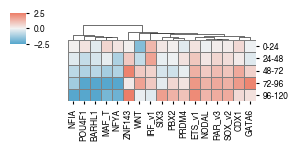

In [25]:
temp = pd.concat([ratios_filter['motif'],0-ratios_filter.iloc[:,1:-1].rsub(ratios_filter['background'] ,axis=0)],axis=1).fillna(0)
temp = temp[np.any(temp.iloc[:,1:].abs()>1,axis=1)].reset_index(drop=True)
design_table = pd.read_table( '../Figure5/98_TF_motif_designs.csv',header=None,sep=',')
temp2 = temp.merge(design_table.iloc[:,[0,4]],left_on='motif',right_on=0,how='left')
temp2.index=list(temp2[4])
df = temp2.iloc[:,1:6]
g=sns.clustermap(data=df.T, cmap=sns.diverging_palette(230,20,l=65, center='light',as_cmap=True,n=10),
                 row_cluster=False,figsize = (3.2, 1.7), # Figure sizes
                 dendrogram_ratio = 0.2,linecolor="grey",
                 xticklabels=True,yticklabels=True,
                 linewidth=.5,cbar=True,annot=False,vmax=2.5,vmin=-2.5)
g.ax_heatmap.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.ax_heatmap.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.ax_heatmap.collections[0].colorbar.ax.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig(f'../Figure5/figs/Cluster_heat_17.pdf')

## Supp Figure 8f All CRE heatmap

In [26]:
ratios_filter = ratios[np.any(ratios.iloc[:,1:]>-9.9,axis=1)].reset_index(drop=True)
temp = pd.concat([ratios_filter['motif'],0-ratios_filter.iloc[:,1:-1].rsub(ratios_filter['background'] ,axis=0)],axis=1).fillna(0)
temp = temp[np.any(temp.iloc[:,1:].abs()>1,axis=1)].reset_index(drop=True)

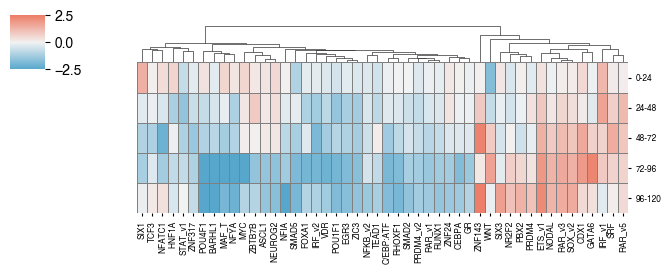

In [27]:
design_table = pd.read_table( '../Figure5/98_TF_motif_designs.csv',header=None,sep=',')
temp2 = temp.merge(design_table.iloc[:,[0,4]],left_on='motif',right_on=0,how='left')
temp2.index=list(temp2[4])
df = temp2.iloc[:,1:6]
g=sns.clustermap(data=df.T, cmap=sns.diverging_palette(230,20,l=65, center='light',as_cmap=True,n=10),
                 row_cluster=False,figsize = (7, 3), # Figure sizes
                 dendrogram_ratio = 0.2,linecolor="grey",
                 xticklabels=1,yticklabels=True,
                 linewidth=.5,cbar=True,annot=False,vmin=-2.5, vmax=2.5)
g.ax_heatmap.xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
g.ax_heatmap.yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
#plt.savefig(f'../Figure5/figs/Cluster_heat_all.pdf')

## Figure 5 f-h line plot with error bar

In [28]:
## Dox mesc
path = '../Figure5/'
times = ['0-24','24-48','48-72','72-96','96-120']
tt = ['0-24','0-24','24-48','24-48','48-72','48-72','72-96','72-96','96-120','96-120']
motifs = ['AAAGATCAAAGGAA','AATCCACA','ACTTCCGGT', 'AAGGTCAATGACCTT',  # wnt, nodal, ets, rar_v3
          'TACCCACAATGCATTG','CGAAACCGAAACT',     # ZNF143, IRF1
          'GCAATAAAA', 'TCTTATCT', 'CATAAATCAT',  # CDX1/2, GATA, PBX1
          'CTGTTTCT','ATAGGGTATCACTAAT','CCATTGTTCGGT'] # PRDM4,SIX3,SOX_v2
ratios = pd.DataFrame(motifs,columns=['motif'])
k = 0
for time in times:
    samples =sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and time in s])
    df_hek = pd.read_table('../Figure5/synEn_designs.txt')
    for i in range(0,2):
        with open(path+samples[i]+'_bc_count.tsv','r') as f:
            temp = f.readlines()
            test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]) if s[1]>10],columns=['barcode','count'])
            test['barcode']=test['barcode'].apply(reverse_complement)
            total = test['count'].sum()
            test = test[test['count']>total/2**14].reset_index(drop=True)
            df_hek=df_hek.merge(test,on='barcode',how='left').fillna(round(total/2**14))
    df_hek.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2']
    df_hek['Hek293_rep1'] = df_hek['Hek293_rep1'].astype(float, copy=True)
    df_hek['Hek293_rep2'] = df_hek['Hek293_rep2'].astype(float, copy=True)
    df_hek['Hek_ratio_rep1'] =  np.log2((df_hek['Hek293_rep1'])/(df_hek['Hek293_rep1'].sum()))#*10**6
    df_hek['Hek_ratio_rep2'] =  np.log2((df_hek['Hek293_rep2'])/(df_hek['Hek293_rep2'].sum()))#*10**6
    
    df_hek['ratio_mean'] =  (df_hek['Hek_ratio_rep1']+df_hek['Hek_ratio_rep2'])/2#*10**6
    ratios = ratios.merge(df_hek[df_hek['motif'].str.contains('|'.join(motifs))][['motif','Hek_ratio_rep1','Hek_ratio_rep2']],on='motif',how='left')
    ratios.columns = ['motif'] + tt[0:2*k+2]
    k+=1

df_hek = pd.read_table('../Figure5/synEn_designs.txt')
samples = sorted([s.split('_bc_count')[0] for s in os.listdir(path) if '.tsv' in s and 'mESC-dox' in s])
for i in range(0,3):
    with open(path+samples[i]+'_bc_count.tsv','r') as f:
        temp = f.readlines()
        test = pd.DataFrame([s for s in merge_edit_1([a for a in [str2array(s) for s in temp] if len(a[0])==5]) if s[1]>10],columns=['barcode','count'])
        test['barcode']=test['barcode'].apply(reverse_complement)
        total = test['count'].sum()
        test = test[test['count']>total/2**14].reset_index(drop=True)
        df_hek=df_hek.merge(test,on='barcode',how='left').fillna(round(total/2**14))
df_hek.columns =  ['motif','barcode','barcode_rc','Sequence','Hek293_rep1','Hek293_rep2','Hek293_rep3']

df_hek['Hek293_rep1'] = df_hek['Hek293_rep1'].astype(float, copy=True)
df_hek['Hek293_rep2'] = df_hek['Hek293_rep2'].astype(float, copy=True)
df_hek['Hek293_rep3'] = df_hek['Hek293_rep3'].astype(float, copy=True)
df_hek['Hek_ratio_rep1'] =  np.log2((df_hek['Hek293_rep1'])/(df_hek['Hek293_rep1'].sum()))#*10**6
df_hek['Hek_ratio_rep2'] =  np.log2((df_hek['Hek293_rep2'])/(df_hek['Hek293_rep2'].sum()))#*10**6
df_hek['Hek_ratio_rep3'] =  np.log2((df_hek['Hek293_rep3'])/(df_hek['Hek293_rep3'].sum()))#*10**6

df_hek['ratio_mean'] =  (df_hek['Hek_ratio_rep1']+df_hek['Hek_ratio_rep2']+df_hek['Hek_ratio_rep3'])/3#*10**6
ratios = ratios.merge(df_hek[df_hek['motif'].str.contains('|'.join(motifs))][['motif','ratio_mean']],on='motif',how='left')
ratios.columns = ['motif']+tt+['background']

In [29]:
temp = pd.concat([ratios['motif'],0-ratios.iloc[:,1:-1].rsub(ratios['background'],axis=0)],axis=1).fillna(0)
design_table = pd.read_table( '../Figure5/98_TF_motif_designs.csv',sep=',')
temp = temp.merge(design_table.iloc[:,0:6],left_on='motif',right_on='motif',how='left')
temp.index=list(temp['identifier'])
df_lineplot = temp.iloc[:,1:11].reset_index().melt(id_vars='index')
colors_all = [ '#0084B8', '#FF9E00', '#F9A5A5', '#3E6B72', '#6E84A3', '#AABDD9', '#78A355', '#E0A458', '#FF5C5C', '#C08C4B', '#D9BADD', '#FFAFAF', '#75A6E8', '#D3A369' ]

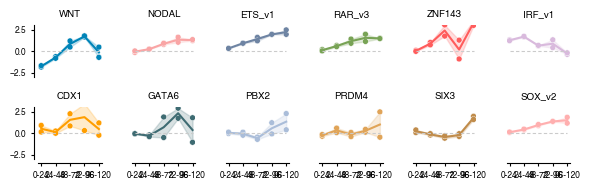

In [30]:
shape = (2,6)
sigs = np.reshape(list(temp.reset_index()['index']),(2,6))
colors = np.reshape(colors_all[:12],(6,2)).T
fig, axs = plt.subplots(shape[0],shape[1],figsize=(6,2),sharey=False,sharex=False)
for i in range(shape[0]):
    for j in range(shape[1]):
        s = sigs[i,j]
        df_plot = df_lineplot[df_lineplot['index']==s]
        g= sns.lineplot(data=df_plot,x='variable',y='value',style="index",
                    color=colors[i,j],dashes=False,ax=axs[i,j],legend=False)  
        sns.scatterplot(data=df_plot,x='variable',y='value',size=3,legend=None,color=colors[i,j],ax=axs[i,j])
        axs[i,j].spines[['top', 'right']].set_visible(False)
        axs[i,j].set_ylim(-3,3)
        axs[i,j].set_ylabel('')
        axs[i,j].set_xlabel('')
        axs[i,j].set_yticks([-2.5,0,2.5])
        axs[i,j].set_title(s,fontsize=7)
        axs[i,j].hlines(y=0, xmin=0, xmax=4, color='#CBCBCB', linestyle=(0, (3, 2)), linewidth=0.8)  
        axs[i,j].xaxis.set_tick_params(width=0.8, length=2,labelsize=6)
        axs[i,j].yaxis.set_tick_params(width=0.8, length=2,labelsize=6)
        axs[i,j].spines['left'].set_position(('outward', 3)) 
        axs[i,j].spines['bottom'].set_position(('outward', 3)) 
        if j>0 and i ==0:
            axs[i,j].spines[['top', 'right','left','bottom']].set_visible(False)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
        elif j>0 and i ==1:
            axs[i,j].spines[['top', 'right','left']].set_visible(False)
            axs[i,j].set_yticks([])
        elif j==0 and i ==0:
            axs[i,j].spines[['top', 'right','bottom']].set_visible(False)
            axs[i,j].set_xticks([])
        elif j==1 and i ==0:
            axs[i,j].spines[['top', 'right']].set_visible(False)
            axs[i,j].set_xticks([])
plt.tight_layout()
#plt.savefig(f'../Figure5/figs/Key_TF_signal_line_6x2.pdf')

# DESEQ 
run with R

In [1]:
suppressPackageStartupMessages({
  options(stringsAsFactors = FALSE)
  library(DESeq2);
  library(data.table);
  library(gdata);
  library(BSgenome);
  library(ggplot2);
  library(RColorBrewer);
  library(biomaRt);
  library(ggrepel);
  library(tidyverse)
  library(glue)})

# mESC vs Cells

In [2]:
design <- as.matrix(read.csv('../Figure5/98_TF_motif_designs.csv',sep=',',header=TRUE,check.names = FALSE))
design_new = data.frame(design[,c(1,2,5,6,7,8)])
cts <- as.matrix(read.csv("../Figure5//mESC_hek_k562_comparison_deseq.csv", sep = ",", row.names='barcode', header = T))
keep <- rowSums(cts) > 1000
cts <- cts[keep,]
colnames(cts) <- gsub("X", "", colnames(cts))
coldata <- read.csv("../Figure5/coldata_mESC_Hek293T_K562.csv", sep = ",", row.names='X0')
rownames(coldata) <- gsub("-", ".", rownames(coldata))
colnames(coldata) <- c('condition')

In [86]:
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData   = coldata,
                              design    = ~ condition)
#res <- results(dds,alpha=0.05)
dds$condition = relevel(dds$condition,3)
dds = DESeq(dds)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## mESC vs K562

In [87]:
comp = 'K562'
res_unshrunken <- results(dds, contrast=c("condition",comp,"mESC"), alpha = 0.05, lfcThreshold = 1)
res <- lfcShrink(dds, coef=glue('condition_{comp}_vs_mESC'), res=res_unshrunken)
res$rowname <- rownames(res)
res_final <- res %>%
  data.frame() %>% 
  as_tibble()%>% arrange(padj)%>% mutate(threshold = padj < 1*1e-3)
res_final <- merge(res_final,design_new,by.x='rowname',by.y='barcode')%>% arrange(padj)
#res_final[0:30,]

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



,rowname,baseMean,log2FoldChange,lfcSE,pvalue,padj,threshold,motif,identifier,V4,V5,V6
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TGTTG,924.0773,5.901583,0.16922608,7.841712e-185,7.135958e-183,TRUE,GGGACTTTCC,NFKB_v1,NFKB,REL,NFKB1\RELA
2,TAGAG,1971.1015,-4.063852,0.13840446,6.576530e-109,2.992321e-107,TRUE,AACACTACCATTGTT,SOX_v1,Soxs,Sox1\Sox11\SOX21,SOX2\Sox3\SOX4\Sox6\SOX8\SOX9\SOX10\SOX12\SOX13\SOX14\SOX15\Sox17\SOX18
3,GTGCA,1594.3595,-3.648982,0.17197623,3.163320e-54,9.595403e-53,TRUE,CTGTTTCT,PRDM4,PRDM4,,
4,TAAGG,3678.3056,-3.368368,0.16349913,3.954651e-48,8.996832e-47,TRUE,CCATTGTTCGGT,SOX_v2,Soxs,Sox1\Sox11\SOX21,SOX2\Sox3\SOX4\Sox6\SOX8\SOX9\SOX10\SOX12\SOX13\SOX14\SOX15\Sox17\SOX18
5,GTAAG,909.8611,3.899018,0.20476627,3.318494e-46,6.039660e-45,TRUE,TACCCACAATGCATTG,ZNF143,ZNF143,,
6,TATGC,1662.2702,2.320009,0.10324606,8.023320e-38,1.216870e-36,TRUE,CACGTGAC,BHLHE40,BHLHE40,TFE3,Creb3l2
7,GTAGT,5301.1111,1.772495,0.06986319,1.192097e-28,1.549726e-27,TRUE,GATGACTCATC,AP-1_TRE,TRE,FOS::JUNB,FOSL2::JUN
8,TTGCC,4657.8292,2.011274,0.09524894,1.429397e-26,1.625939e-25,TRUE,GTTACGTAAT,NFIL3,NFIL3,HLF,TEF/DBP heterodimer
9,CGTAT,4747.6983,-2.009888,0.10966854,1.590759e-20,1.608434e-19,TRUE,GACCCCCCGCTGTGC,ZIC3,ZIC1\ZIC3\ZIC4\ZIC5,,


In [88]:
pdf(file = "../Figure5/figs/syn_rec_des_k562.pdf",   # The directory you want to save the file in
    width = 2, # The width of the plot in inches
    height = 1.5) # The height of the plot in inches
p1 <- ggplot(res_final, aes(x = log2FoldChange, y = -log10(padj))) +
        geom_point(aes(colour = threshold),size=1 ) + 
        scale_color_manual(values=c("#5C5C5C", "#FB8072"))+
        xlab("") + 
        ylab("") + 
        scale_x_continuous(limits = c(-6,6))+
        scale_y_continuous(limits = c(0., 200))+ 
        theme_classic() + 
        theme(legend.position="none",
              axis.text = element_text(size = 6),
              axis.title = element_text(size = 7),
              axis.ticks.length=unit(2,"pt"),
              axis.ticks = element_line(size=72.27/96*0.5),
              axis.line = element_line(color="black", size = 72.27/96*0.5))
p1
dev.off()

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


png 
  2

## mESC vs Hek293

In [90]:
comp = 'Hek293'
res_unshrunken <- results(dds, contrast=c("condition",comp,"mESC"), alpha = 0.05, lfcThreshold = 1)
res <- lfcShrink(dds, coef=glue('condition_{comp}_vs_mESC'), res=res_unshrunken)
res$rowname <- rownames(res)
res_final <- res %>%
  data.frame() %>% 
  as_tibble()%>% arrange(padj)%>% mutate(threshold = padj < 1*1e-3)
res_final <- merge(res_final,design_new,by.x='rowname',by.y='barcode')%>% arrange(padj)
#res_final[0:30,]

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [91]:
pdf(file = "../Figure5/figs/syn_rec_des_hek293.pdf",   # The directory you want to save the file in
    width = 2, # The width of the plot in inches
    height = 1.5) # The height of the plot in inches
p1 <- ggplot(res_final, aes(x = log2FoldChange, y = -log10(padj))) +
        geom_point(aes(colour = threshold),size=1 ) + 
        scale_color_manual(values=c("#5C5C5C", "#FB8072"))+
        xlab("") + 
        ylab("") + 
        scale_x_continuous(limits = c(-4,4))+
        scale_y_continuous(limits = c(0., 125))+ 
        theme_classic() + 
        theme(legend.position="none",
              axis.text = element_text(size = 6),
              axis.title = element_text(size = 7),
              axis.ticks.length=unit(2,"pt"),
              axis.ticks = element_line(size=72.27/96*0.5),
              axis.line = element_line(color="black", size = 72.27/96*0.5))
p1
dev.off()

png 
  2

## Hek293 vs K562

In [3]:
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData   = coldata,
                              design    = ~ condition)
dds = DESeq(dds)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [4]:
# new counts don do
res_unshrunken <- results(dds, contrast=c("condition","K562","Hek293"), alpha = 0.05, lfcThreshold = 1)
res <- lfcShrink(dds, coef='condition_K562_vs_Hek293', res=res_unshrunken)

res$rowname <- rownames(res)
res_final <- res %>%
  data.frame() %>% 
  as_tibble()%>% arrange(padj)%>% mutate(threshold = padj < 1e-3)
res_final <- merge(res_final,design_new,by.x='rowname',by.y='barcode')%>% arrange(padj)
#res_final[0:50,]

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [95]:
pdf(file = "../Figure2/figs/Fig2g_syn_rec_des_hek293_vs_k562.pdf",   # The directory you want to save the file in
    width = 2, # The width of the plot in inches
    height = 1.5) # The height of the plot in inches
p1 <- ggplot(res_final, aes(x = log2FoldChange, y = -log10(padj))) +
        geom_point(aes(colour = threshold),size=1 ) + 
        scale_color_manual(values=c("#5C5C5C", "#FB8072"))+
        xlab("") + 
        ylab("") + 
        scale_x_continuous(limits = c(-4,4))+
        scale_y_continuous(limits = c(0., 65))+ 
        theme_classic() + 
        theme(legend.position="none",
              axis.text = element_text(size = 6),
              axis.title = element_text(size = 7),
              axis.ticks.length=unit(2,"pt"),
              axis.ticks = element_line(size=72.27/96*0.5),
              axis.line = element_line(color="black", size = 72.27/96*0.5))
p1
dev.off()

Warning message:
“Removed 19 rows containing missing values (`geom_point()`).”


png 
  2

# mESC vs Gastruloid

In [6]:
design <- as.matrix(read.csv('../Figure5/98_TF_motif_designs.csv',sep=',',header=TRUE,check.names = FALSE))
design_new = data.frame(design[,c(1,2,3,5,6,7,8)])

cts <- as.matrix(read.csv("../Figure5/mESC_gas_tf_recording.csv", sep = ",", row.names='motif', header = T))
colnames(cts) <- gsub("X", "", colnames(cts))

keep <- rowSums(cts) > 1500
cts <- cts[keep,]
coldata <- read.csv("../Figure5/coldata_mESC_gas.csv", sep = ",", row.names='X0')
rownames(coldata) <- gsub("-", ".", rownames(coldata))
colnames(coldata) <- c('condition')

dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData   = coldata,
                              design    = ~ condition)
#res <- results(dds,alpha=0.05)
dds$condition = relevel(dds$condition, 6)
dds = DESeq(dds)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [13]:
comp = '0.24'
comp = '24.48'
comp = '48.72'
comp = '72.96'
comp = '96.120'
res_unshrunken <- results(dds, contrast=c("condition",comp,"mESC.dox"), alpha = 0.05, lfcThreshold = 0.9)
res <- lfcShrink(dds, coef=glue('condition_{comp}_vs_mESC.dox'), res=res_unshrunken,type='apeglm')
res$rowname <- rownames(res)
res_final <- res %>%
  data.frame() %>% 
  as_tibble()%>% arrange(padj)%>% mutate(threshold = padj < 1*1e-1)
res_final <- merge(res_final,design_new,by.x='rowname',by.y='motif')%>% arrange(padj)
#res_final[0:20,]
write_csv(res_final,glue('../Figure5/{comp}_deseq.txt'))

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

